<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
# <font color='blue'>MLOps e Ciclo de Vida de Modelos de Machine Learning</font>
## <font color='blue'>Projeto 1</font>
### <font color='blue'>MLOps Stack Para Otimização de Hiperparâmetros com MLflow e Optuna</font>

## Instalação, Carregamento e Gerenciamento de Pacotes

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [2]:
!pip install -q optuna

In [3]:
!pip install -q mlflow

In [4]:
!pip install -q xgboost

In [1]:
# Imports
import json
import math
import sklearn
import optuna
import mlflow
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" 

Author: Data Science Academy



## Inicializando o Servidor MLflow

Abra um prompt de comando ou terminal, navegue até a pasta do projeto e digite o comando abaixo:

mlflow server --host 127.0.0.1 --port 8282

> Agora conectamos no servidor MLflow:

In [3]:
mlflow.set_tracking_uri("http://127.0.0.1:8282")

Acesse a url acima a partir de outra aba no seu navegador: http://127.0.0.1:8282

## Carregando e Compreendendo os Dados

In [4]:
# Carrega o dataset
df_dsa = pd.read_csv("dataset.csv")

In [5]:
# Shape
df_dsa.shape

(5000, 11)

In [6]:
# Amostra dos dados
df_dsa.head()

data  temperatura_media  precipitacao  fim_de_semana  \
0  2010-10-18 09:16:07.883826          30.584727      1.199291              0   
1  2010-10-19 09:16:07.883825          15.465069      1.037626              0   
2  2010-10-20 09:16:07.883824          10.786525      5.656089              0   
3  2010-10-21 09:16:07.883823          23.648154     12.030937              0   
4  2010-10-22 09:16:07.883822          13.861391      4.303812              0   

   feriado  preco_por_kg  promocao      demanda  demanda_dos_dias_anteriores  \
0        0      1.726258         1  1051.375336                  1051.276659   
1        0      0.576471         1  1106.855943                  1051.276659   
2        0      2.513328         1  1008.304909                  1106.836626   
3        0      1.839225         1   999.833810                  1057.895424   
4        0      1.531772         1  1183.949061                  1048.961007   

   preco_por_kg_do_concorrente  intensidade_de_marketing  
0                     1.935346                  0.098677  
1                     2.344720                  0.019318  
2                     0.998803                  0.409485  
3                     0.761740                  0.872803  
4                     2.123436                  0.820779

In [7]:
# Tipos dos dados
df_dsa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   data                         5000 non-null   object 
 1   temperatura_media            5000 non-null   float64
 2   precipitacao                 5000 non-null   float64
 3   fim_de_semana                5000 non-null   int64  
 4   feriado                      5000 non-null   int64  
 5   preco_por_kg                 5000 non-null   float64
 6   promocao                     5000 non-null   int64  
 7   demanda                      5000 non-null   float64
 8   demanda_dos_dias_anteriores  5000 non-null   float64
 9   preco_por_kg_do_concorrente  5000 non-null   float64
 10  intensidade_de_marketing     5000 non-null   float64
dtypes: float64(7), int64(3), object(1)
memory usage: 429.8+ KB


In [8]:
# Vamos ajustar a coluna de data para o tipo correto
df_dsa['data'] = pd.to_datetime(df_dsa['data'])

In [9]:
# Tipos dos dados
df_dsa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   data                         5000 non-null   datetime64[ns]
 1   temperatura_media            5000 non-null   float64       
 2   precipitacao                 5000 non-null   float64       
 3   fim_de_semana                5000 non-null   int64         
 4   feriado                      5000 non-null   int64         
 5   preco_por_kg                 5000 non-null   float64       
 6   promocao                     5000 non-null   int64         
 7   demanda                      5000 non-null   float64       
 8   demanda_dos_dias_anteriores  5000 non-null   float64       
 9   preco_por_kg_do_concorrente  5000 non-null   float64       
 10  intensidade_de_marketing     5000 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(3)


In [10]:
# Resumo estatístico
df_dsa.describe()

temperatura_media  precipitacao  fim_de_semana      feriado  \
count        5000.000000   5000.000000    5000.000000  5000.000000   
mean           22.433182      4.962877       0.285600     0.033000   
std             7.146610      4.932382       0.451745     0.178654   
min            10.002439      0.000071       0.000000     0.000000   
25%            16.311898      1.440718       0.000000     0.000000   
50%            22.400265      3.520515       0.000000     0.000000   
75%            28.570768      6.805668       1.000000     0.000000   
max            34.995334     40.072693       1.000000     1.000000   

       preco_por_kg     promocao      demanda  demanda_dos_dias_anteriores  \
count   5000.000000  5000.000000  5000.000000                  5000.000000   
mean       1.758228     0.289000  1258.452333                  1282.446665   
std        0.725334     0.453343   253.240475                   249.087488   
min        0.500360     0.000000   707.952882                   757.216503   
25%        1.134110     0.000000  1066.040653                  1089.993191   
50%        1.776194     0.000000  1222.237635                  1244.619215   
75%        2.383638     1.000000  1422.792698                  1445.791858   
max        2.999606     1.000000  2183.463942                  2182.608701   

       preco_por_kg_do_concorrente  intensidade_de_marketing  
count                  5000.000000               5000.000000  
mean                      1.769682                  0.848173  
std                       0.721041                  0.093135  
min                       0.500754                  0.019318  
25%                       1.160719                  0.773080  
50%                       1.764809                  0.848107  
75%                       2.401827                  0.928536  
max                       2.999847                  0.999979

<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
## Carregando e Compreendendo os Metadados (Dicionário)

In [11]:
# Carrega o arquivo JSON
with open('dicionario_de_dados.json', 'r') as arquivo:
    dicionario_de_dados = json.load(arquivo)

In [12]:
# Cria um DataFrame a partir do dicionário de metadados
df_dict = pd.DataFrame.from_dict(dicionario_de_dados, orient = 'index')

In [13]:
# Não truncar colunas no Pandas
pd.set_option('display.max_colwidth', None)

In [14]:
df_dict

descrição  \
data                                                                          Data e hora em que os dados foram registrados.   
temperatura_media                                                                      Temperatura média registrada na data.   
precipitacao                                                                  Quantidade de precipitação registrada na data.   
fim_de_semana                                                             Indica se o dia é um fim de semana (1) ou não (0).   
feriado                                                                         Indica se o dia é um feriado (1) ou não (0).   
preco_por_kg                                                                                Preço por kg do produto vendido.   
promocao                                                                  Indica se havia uma promoção ativa (1) ou não (0).   
demanda                                                                                          Demanda do produto na data.   
demanda_dos_dias_anteriores                                                              Demanda do produto no dia anterior.   
preco_por_kg_do_concorrente                                            Preço por kg do produto oferecido por um concorrente.   
intensidade_de_marketing     Nível de intensidade das atividades de marketing (campanhas, anúncios) relacionadas ao produto.   

                                 tipo  
data                         datetime  
temperatura_media               float  
precipitacao                    float  
fim_de_semana                     int  
feriado                           int  
preco_por_kg                    float  
promocao                          int  
demanda                         float  
demanda_dos_dias_anteriores     float  
preco_por_kg_do_concorrente     float  
intensidade_de_marketing        float

<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
## Funções de Exploração e Visualização dos Dados Para o Experimento

In [15]:
# Função para o plot da correlação das variáveis preditoras com a variável alvo (demanda)
def dsa_plot_corr_demanda(df, save_path = None):

    # Calcula as correlações das variáveis com a demanda, exceto a própria demanda
    correlations = df.corr()["demanda"].drop("demanda").sort_values()

    # Define uma paleta de cores divergentes
    colors = sns.diverging_palette(10, 130, as_cmap = True)
    
    # Mapeia as cores às correlações
    color_mapped = correlations.map(colors)

    # Define o estilo do gráfico
    sns.set_style("darkgrid", {"axes.facecolor": "#eaeaf2", "grid.linewidth": 1.5})

    # Cria a figura do plot com tamanho definido
    fig = plt.figure(figsize = (12, 8))
    
    # Cria um gráfico de barras horizontais para as correlações
    plt.barh(correlations.index, correlations.values, color = color_mapped)

    # Define o título e os rótulos dos eixos do gráfico
    plt.title("Correlação com Demanda", fontsize = 16)
    plt.xlabel("Coeficiente de Correlação", fontsize = 14)
    plt.ylabel("Variável", fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.grid(axis="x")

    # Ajusta o layout para evitar sobreposição
    plt.tight_layout()

    # Salva o gráfico como um arquivo PNG, se um caminho for fornecido
    if save_path:
        plt.savefig(save_path, format = "png", dpi = 600)

    # Fecha a figura para liberar memória
    plt.close(fig)

    # Retorna a figura criada
    return fig

In [16]:
# Executa a função
dsa_grafico1 = dsa_plot_corr_demanda(df_dsa)

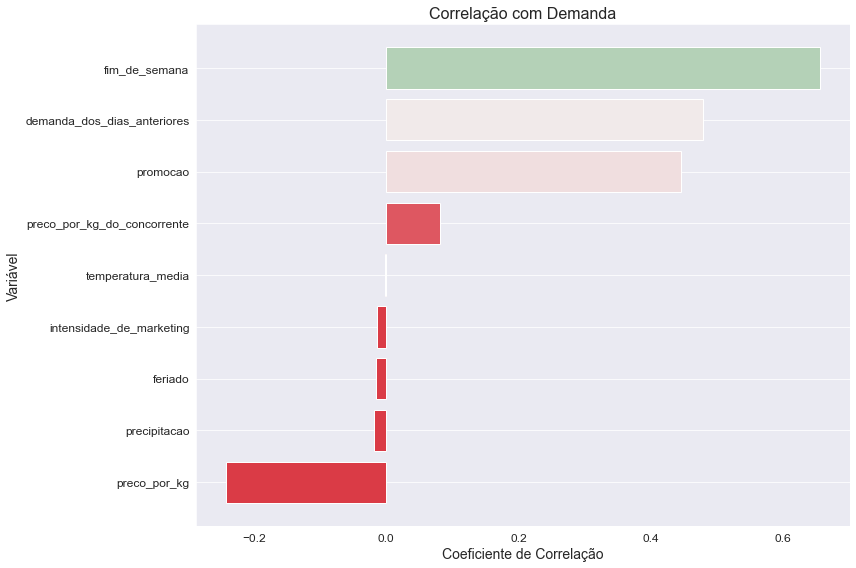

In [17]:
dsa_grafico1

In [18]:
# Função para plot dos resíduos do modelo
def dsa_plot_residuos(model, dvalid, valid_y, save_path = None):

    # Faz as previsões no conjunto de validação
    preds = model.predict(dvalid)

    # Calcula os resíduos (diferença entre valores reais e previstos)
    residuals = valid_y - preds

    # Define o estilo do gráfico para 'whitegrid'
    sns.set_style("whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5})

    # Cria a figura do plot com tamanho definido
    fig = plt.figure(figsize = (12, 8))
    
    # Cria um gráfico de dispersão dos valores reais versus resíduos
    plt.scatter(valid_y, residuals, color = "blue", alpha = 0.5)
    
    # Adiciona uma linha horizontal em y=0
    plt.axhline(y = 0, color = "r", linestyle = "-")

    # Define o título e os rótulos dos eixos do gráfico
    plt.title("Resíduos x Valores Reais", fontsize = 16)
    plt.xlabel("Valores Reais", fontsize = 14)
    plt.ylabel("Resíduos", fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.grid(axis = "y")

    # Ajusta o layout para evitar sobreposição
    plt.tight_layout()

    # Salva o gráfico como um arquivo PNG, se um caminho for fornecido
    if save_path:
        plt.savefig(save_path, format = "png", dpi = 600)

    # Fecha a figura para liberar memória
    plt.close(fig)

    # Retorna a figura criada
    return fig

In [19]:
# Função para plot da importância das variáveis
def dsa_plot_feature_importance(model, booster):

    # Cria a figura e o eixo para o plot com tamanho definido
    fig, ax = plt.subplots(figsize = (10, 8))
    
    # Define o tipo de importância como "weight" se o booster for "gblinear", caso contrário "gain"
    importance_type = "weight" if booster == "gblinear" else "gain"
    
    # Plot das importância das variáveis usando o XGBoost
    xgb.plot_importance(model,
                        importance_type = importance_type,
                        ax = ax,
                        title = f"Feature Importance baseada em {importance_type}")
    
    # Ajusta o layout para evitar sobreposição
    plt.tight_layout()
    
    # Fecha a figura para liberar memória
    plt.close(fig)

    # Retorna a figura criada
    return fig

## Criando o Experimento no MLflow

In [20]:
# Função para criar o experimento
def dsa_cria_experimento(experiment_name):

    # Verifica se o experimento já existe pelo nome
    if experiment := mlflow.get_experiment_by_name(experiment_name):
        # Se o experimento existir, retorna seu ID
        return experiment.experiment_id
    else:
        # Se o experimento não existir, cria um novo e retorna seu ID
        return mlflow.create_experiment(experiment_name)

In [21]:
# Cria o experimento
id_experimento_dsa_p1 = dsa_cria_experimento("DSAProjeto1")

In [22]:
# Experimento criado
id_experimento_dsa_p1

'692186374947409346'

Visualize no seu navegador: http://127.0.0.1:8282

In [23]:
# Define o experimento MLflow ativo atual
mlflow.set_experiment(experiment_id = id_experimento_dsa_p1)

<Experiment: artifact_location='mlflow-artifacts:/692186374947409346', creation_time=1752665430453, experiment_id='692186374947409346', last_update_time=1752665430453, lifecycle_stage='active', name='DSAProjeto1', tags={}>

<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
## Pré-Processamento dos Dados Para o Experimento

Acompanhe o videobook no Capítulo 6 do curso.

In [24]:
# Separa em X e y
X = df_dsa.drop(columns = ["data", "demanda"])
y = df_dsa["demanda"]

In [25]:
# Divide os dados em treino e validação
x_treino, x_valid, y_treino, y_valid = train_test_split(X, y, test_size = 0.25)

In [26]:
# Coloca os dados no formato de matriz do XGBoost
dsa_treino = xgb.DMatrix(x_treino, label = y_treino)
dsa_valid = xgb.DMatrix(x_valid, label = y_valid)

In [27]:
# Substitui o registro padrão do Optuna apenas para ERROR
optuna.logging.set_verbosity(optuna.logging.ERROR)

## Definindo o Callback de Logging

Registro de retorno de chamada que informará quando uma nova iteração de teste melhorar a existente.

In [28]:
# Função de callback
def dsa_callback(study, frozen_trial):

    # Obtém o valor atual do "winner" (vencedor) dos atributos do estudo
    winner = study.user_attrs.get("winner", None)

    # Verifica se há um novo melhor valor e se o "winner" não é igual ao melhor valor
    if study.best_value and winner != study.best_value:
        
        # Define o novo melhor valor como "winner"
        study.set_user_attr("winner", study.best_value)
        
        # Se havia um "winner" anterior
        if winner:
            
            # Calcula a porcentagem de melhoria em relação ao "winner" anterior
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            
            # Imprime o número da tentativa, o valor alcançado e a porcentagem de melhoria
            print(
                f"Tentativa {frozen_trial.number} alcançou o valor: {frozen_trial.value} com "
                f"{improvement_percent: .4f}% de melhora na métrica de avaliação.")
        else:
            # Se não havia um "winner" anterior, imprime o número da tentativa inicial e o valor alcançado
            print(
                f"Tentativa inicial {frozen_trial.number} alcançou o valor: "
                f"{frozen_trial.value} na métrica de avaliação.")

## Definindo os Hiperparâmetros do XGBoost Para o Experimento

Acompanhe o videobook no Capítulo 6 do curso.

In [29]:
# Função para definir os hiperparâmetros que serão otimizados
def dsa_otimiza_hiperparametro(trial):
    
    # Inicia uma nova execução de MLflow
    with mlflow.start_run(nested = True):
        
        # Define os hiperparâmetros básicos do modelo
        params = {
            
            # Função alvo (objetivo)
            "objective": "reg:squarederror",
            
            # Métrica de avaliação
            "eval_metric": "rmse",
            
            # Tipo de booster (algoritmo de treinamento)
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            
            # Valor de lambda para regularização L2
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log = True),
            
            # Valor de alpha para regularização L1
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log = True),
        }

        # Se o booster for 'gbtree' ou 'dart', adiciona parâmetros específicos
        if params["booster"] == "gbtree" or params["booster"] == "dart":
            
            # Profundidade máxima da árvore
            params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            
            # Valor de eta (taxa de aprendizado)
            params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            
            # Valor de gamma para regularização adicional
            params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            
            # Política de crescimento das árvores
            params["grow_policy"] = trial.suggest_categorical(
                "grow_policy", ["depthwise", "lossguide"]
            )

        # Treina o modelo com os hiperparâmetros escolhidos
        bst = xgb.train(params, dsa_treino)
        
        # Faz previsões no conjunto de validação
        preds = bst.predict(dsa_valid)
        
        # Calcula o erro quadrático médio
        error = mean_squared_error(y_valid, preds)

        # Registra os parâmetros no MLflow
        mlflow.log_params(params)
        
        # Registra o MSE no MLflow
        mlflow.log_metric("mse", error)
        
        # Registra o RMSE no MLflow
        mlflow.log_metric("rmse", math.sqrt(error))

    # Retorna o erro calculado
    return error

## Executando o Experimento com MLflow e Optuna

In [30]:
# Nome para a execução no MLflow
run_name = "dsa_p1"

In [35]:
# Inicia a execução de ajuste de hiperparâmetros
with mlflow.start_run(experiment_id = id_experimento_dsa_p1, run_name = run_name, nested = True):
    
    # Cria um estudo Optuna para otimização de hiperparâmetros para minimizar a função alvo (função de erro)
    study = optuna.create_study(direction = "minimize")

    # Otimiza os hiperparâmetros com 500 tentativas, usando a função de callback
    study.optimize(dsa_otimiza_hiperparametro, n_trials = 500, callbacks = [dsa_callback])

    # Registra os melhores hiperparâmetros encontrados no MLflow
    mlflow.log_params(study.best_params)
    
    # Registra o melhor valor de MSE encontrado no MLflow
    mlflow.log_metric("best_mse", study.best_value)
    
    # Calcula e registra o melhor valor de RMSE no MLflow
    mlflow.log_metric("best_rmse", math.sqrt(study.best_value))

    # Define tags para a execução no MLflow
    mlflow.set_tags(tags = {"project": "DSA MLOps Projeto 1",
                            "optimizer_engine": "optuna",
                            "model_family": "xgboost",
                            "feature_set_version": 1})

    # Treina o modelo com os melhores parâmetros encontrados
    model = xgb.train(study.best_params, dsa_treino)

    # Registra o gráfico dsa_grafico1 no MLflow
    mlflow.log_figure(figure = dsa_grafico1, artifact_file = "dsa_grafico1.png")

    # Plota e registra a importância das variáveis no MLflow
    importances = dsa_plot_feature_importance(model, booster = study.best_params.get("booster"))
    mlflow.log_figure(figure = importances, artifact_file = "dsa_grafico2.png")

    # Plota e registra os resíduos no MLflow
    residuals = dsa_plot_residuos(model, dsa_valid, y_valid)
    mlflow.log_figure(figure = residuals, artifact_file = "dsa_grafico3.png")

    # Define o caminho do artefato do modelo
    artifact_path = "model"

    # Registra o modelo treinado no MLflow
    mlflow.xgboost.log_model(xgb_model = model,
                             artifact_path = artifact_path,
                             input_example = x_treino.iloc[[0]],
                             model_format = "ubj",
                             metadata = {"model_data_version": 1})

    # Obtém a URI do artefato do modelo registrado
    model_uri = mlflow.get_artifact_uri(artifact_path)

Tentativa inicial 0 alcançou o valor: 19461.12984824287 na métrica de avaliação.
Tentativa 11 alcançou o valor: 19286.061371589745 com  0.9077% de melhora na métrica de avaliação.
Tentativa 14 alcançou o valor: 19210.258177653282 com  0.3946% de melhora na métrica de avaliação.
Tentativa 17 alcançou o valor: 19090.124655126874 com  0.6293% de melhora na métrica de avaliação.
Tentativa 26 alcançou o valor: 19032.126097767657 com  0.3047% de melhora na métrica de avaliação.
Tentativa 28 alcançou o valor: 18498.824250214286 com  2.8829% de melhora na métrica de avaliação.
Tentativa 41 alcançou o valor: 18000.910703678524 com  2.7660% de melhora na métrica de avaliação.
Tentativa 47 alcançou o valor: 17429.578193901692 com  3.2779% de melhora na métrica de avaliação.
Tentativa 49 alcançou o valor: 17317.130291511443 com  0.6493% de melhora na métrica de avaliação.
Tentativa 55 alcançou o valor: 17224.267065005482 com  0.5391% de melhora na métrica de avaliação.
Tentativa 86 alcançou o valo

Visualize no seu navegador: http://127.0.0.1:8282

In [31]:
# ----------------------------------------------------------
# IMPORTS
# ----------------------------------------------------------
import math, optuna, mlflow, xgboost as xgb, tempfile, shutil
from sklearn.metrics import mean_squared_error
try:
    from mlflow.models.signature import infer_signature   # MLflow ≤ 3.1
except ImportError:
    from mlflow.models import infer_signature             # MLflow ≥ 3.2

# ----------------------------------------------------------
# EXPERIMENTO / RUN PRINCIPAL
# ----------------------------------------------------------
run_name = "dsa_p1"
mlflow.set_experiment(experiment_id=id_experimento_dsa_p1)

with mlflow.start_run(run_name=run_name):

    # 1) Otuna (500 trials, nested internamente)
    study = optuna.create_study(direction="minimize")
    study.optimize(dsa_otimiza_hiperparametro, n_trials=10, callbacks=[dsa_callback])

    # 2) log melhores params / métricas
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_mse", study.best_value)
    mlflow.log_metric("best_rmse", math.sqrt(study.best_value))
    mlflow.set_tags({
        "project": "DSA MLOps Projeto 1",
        "optimizer_engine": "optuna",
        "model_family": "xgboost",
        "feature_set_version": 1
    })

    # 3) treino final
    model = xgb.train(study.best_params, dsa_treino)

    # 4) figuras na raiz
    mlflow.log_figure(dsa_grafico1, "dsa_grafico1.png")
    mlflow.log_figure(
        dsa_plot_feature_importance(model, booster=study.best_params["booster"]),
        "dsa_grafico2.png"
    )
    mlflow.log_figure(
        dsa_plot_residuos(model, dsa_valid, y_valid),
        "dsa_grafico3.png"
    )

    # 5) assinatura
    signature = infer_signature(x_treino, model.predict(dsa_valid))

    # ------------------------------------------------------
    # 6) SALVA → LOGA MANUALMENTE A PASTA `model/`
    # ------------------------------------------------------
    tmp_dir = tempfile.mkdtemp()                # cria dir temporário
    xgb_save_path = f"{tmp_dir}/model"          # (sub)pasta 'model' dentro dele

    # salva o booster (+ MLmodel, conda.yml etc.)
    mlflow.xgboost.save_model(
        model,
        path            = xgb_save_path,
        input_example   = x_treino.iloc[[0]],
        signature       = signature,
        model_format    = "ubj",
        metadata        = {"model_data_version": 1}
    )

    # faz o upload da pasta inteira como artefato "model/"
    mlflow.log_artifacts(xgb_save_path, artifact_path="model")

    # limpa o temp dir local
    shutil.rmtree(tmp_dir)

print("✅ Modelo e gráficos salvos – veja se 'model/' aparece agora em Artifacts.")


🏃 View run intrigued-stag-645 at: http://127.0.0.1:8282/#/experiments/692186374947409346/runs/5cce1bee80c647108eac845ba666f0bc
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/692186374947409346
Tentativa inicial 0 alcançou o valor: 21717.775875463045 na métrica de avaliação.
🏃 View run powerful-crow-214 at: http://127.0.0.1:8282/#/experiments/692186374947409346/runs/e22bdd0df0e6450689d2b3c40d8e394e
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/692186374947409346
Tentativa 1 alcançou o valor: 19587.045024203286 com  10.8783% de melhora na métrica de avaliação.
🏃 View run shivering-toad-840 at: http://127.0.0.1:8282/#/experiments/692186374947409346/runs/36747fecead24e43b226d72466862487
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/692186374947409346
🏃 View run painted-stork-84 at: http://127.0.0.1:8282/#/experiments/692186374947409346/runs/3847a3e704a140da85a29e1e38b83432
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/692186374947409346
🏃 View

2025/07/16 08:31:12 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\VICTOR~1.FRA\AppData\Local\Temp\tmp1dj382q2\model, flavor: xgboost). Fall back to return ['xgboost==2.1.4']. Set logging level to DEBUG to see the full traceback. 


🏃 View run dsa_p1 at: http://127.0.0.1:8282/#/experiments/692186374947409346/runs/963afca8b94b45319402e032c777e6a8
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/692186374947409346
✅ Modelo e gráficos salvos – veja se 'model/' aparece agora em Artifacts.


## Carregando o Modelo a Partir dos Artefatos

In [32]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

# Filtra exatamente o run pelo nome
papa = client.search_runs(
    experiment_ids=[id_experimento_dsa_p1],
    filter_string='tag.mlflow.runName = "dsa_p1"')[0]   # pega o primeiro (deve ser só 1)

run_id_pai = papa.info.run_id
print("RUN pai  :", run_id_pai)
print("URI base :", papa.info.artifact_uri)   # ← URI absoluta exibida na UI




RUN pai  : 963afca8b94b45319402e032c777e6a8
URI base : mlflow-artifacts:/692186374947409346/963afca8b94b45319402e032c777e6a8/artifacts


In [37]:
model_uri_abs


'mlflow-artifacts:/692186374947409346/963afca8b94b45319402e032c777e6a8/artifacts/model'

In [40]:
# Forma curta
model_uri = f"runs:/{run_id_pai}/model"

# Forma absoluta (equivalente, se preferir copiar/colar da UI)
model_uri_abs = f"{papa.info.artifact_uri}/model/"


In [41]:
import mlflow.xgboost
booster = mlflow.xgboost.load_model(model_uri_abs)   # ou model_uri_abs

# Confere hiperparâmetros (flatten_last)
import json
def flatten_last(d):
    out, stack = {}, [d]
    while stack:
        cur = stack.pop()
        for k, v in cur.items():
            if isinstance(v, dict):
                stack.append(v)
            else:
                out[k] = v          # mantém o último (real)
    return out

flat = flatten_last(json.loads(booster.save_config())["learner"])
for p in ["booster", "max_depth", "eta", "gamma", "reg_lambda", "reg_alpha", "grow_policy"]:
    print(f"{p:11}: {flat.get(p)}")


booster    : gbtree
max_depth  : 6
eta        : 0.300000012
gamma      : 0
reg_lambda : 1
reg_alpha  : 0
grow_policy: depthwise


In [43]:
dsa_melhor_modelo = mlflow.xgboost.load_model(model_uri_abs)

In [47]:
import json

def flatten_keep_last(d):
    """
    Varre recursivamente um dicionário e devolve outro com todas
    as folhas; se uma chave aparece várias vezes, fica o **último** valor.
    """
    flat, pilha = {}, [d]
    while pilha:
        node = pilha.pop()
        for k, v in node.items():
            if isinstance(v, dict):
                pilha.append(v)
            else:
                flat[k] = v          # sobrescreve sempre → guarda o valor real
    return flat

# lê a configuração completa do Booster
cfg = json.loads(dsa_melhor_modelo.save_config())

# achatamos só o bloco "learner" — o resto (training settings) não interessa aqui
flat = flatten_keep_last(cfg["learner"])

# parâmetros que você salvou no MLflow
for p in ["booster", "max_depth", "eta", "gamma",
          "lambda", "alpha", "grow_policy"]:
    print(f"{p:11}: {flat.get(p)}")


booster    : gbtree
max_depth  : 6
eta        : 0.300000012
gamma      : 0
lambda     : 1
alpha      : 0
grow_policy: depthwise


In [48]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_valid,
                                  dsa_melhor_modelo.predict(dsa_valid)))
print("RMSE reproduzido:", rmse)


RMSE reproduzido: 128.33870257148664


In [49]:
import json

def hiperparams_reais(booster):
    """
    Retorna dicionário com hiperparâmetros tal como foram
    usados no treino (sobrepõe defaults e resolve sinônimos).
    """
    cfg  = json.loads(booster.save_config())["learner"]

    # 1. Achata mantendo o ÚLTIMO valor de cada chave
    flat = {}
    stack = [cfg]
    while stack:
        node = stack.pop()
        for k, v in node.items():
            if isinstance(v, dict):
                stack.append(v)
            else:
                flat[k] = v          # sobrepõe sempre

    # 2. Normaliza sinônimos
    if "reg_lambda" in flat and "lambda" not in flat:
        flat["lambda"] = flat["reg_lambda"]
    if "reg_alpha" in flat and "alpha" not in flat:
        flat["alpha"] = flat["reg_alpha"]

    return {k: flat.get(k) for k in
            ["booster", "max_depth", "eta",
             "gamma", "lambda", "alpha", "grow_policy"]}


In [50]:
hp_reais = hiperparams_reais(dsa_melhor_modelo)
print(hp_reais)


{'booster': 'gbtree', 'max_depth': '6', 'eta': '0.300000012', 'gamma': '0', 'lambda': '1', 'alpha': '0', 'grow_policy': 'depthwise'}


In [52]:
model_uri

'runs:/57a0254031d247f28f4f7cdb3098ce89/model'

In [48]:
# 2. Construir a URI do modelo
model_uri = f"runs:/{run_id}/model"

# 3. Carregar o Booster
dsa_melhor_modelo = mlflow.xgboost.load_model(model_uri)

In [53]:
import json, collections

def flatten_last(node):
    """Varre o dicionário e, se houver chaves repetidas,
       mantém o ÚLTIMO valor encontrado (não o primeiro)."""
    flat = {}
    stack = [node]
    while stack:
        cur = stack.pop()
        if isinstance(cur, dict):
            for k, v in cur.items():
                if isinstance(v, dict):
                    stack.append(v)
                else:
                    flat[k] = v          # ← sempre sobrescreve
    return flat

cfg  = json.loads(dsa_melhor_modelo.save_config())
flat = flatten_last(cfg["learner"])          # só o bloco learner é suficiente

for p in ["booster", "max_depth", "eta", "gamma",
          "reg_lambda", "reg_alpha", "grow_policy"]:
    print(f"{p:11}: {flat.get(p)}")


booster    : dart
max_depth  : 6
eta        : 0.300000012
gamma      : 0
reg_lambda : 1
reg_alpha  : 0
grow_policy: depthwise


In [40]:
# Caminho para o melhor modelo (com melhor combinação de hiperparâmetros) salvo em disco
model_uri

'mlflow-artifacts:/634537617003580188/ce8abb89c2084573bb0394ee6ab4dbee/artifacts/model'

In [37]:
# Carrega o melhor modelo do disco
dsa_melhor_modelo = mlflow.xgboost.load_model(model_uri)

## Pipeline de Inferência com o Melhor Modelo

In [51]:
# Gera um batch de dados a partir de X (variáveis preditoras)
batch_dmatrix = xgb.DMatrix(X)

In [52]:
# Faz a inferência (previsões) usando o melhor modelo - ATENÇÃO: ISSO NÃO É DEPLOY!!!!
inferencia = dsa_melhor_modelo.predict(batch_dmatrix)

In [53]:
# Cria cópia do dataframe original
df_final = df_dsa.copy()

In [54]:
# Cria uma coluna com as previsões
df_final["demanda_prevista"] = inferencia

In [56]:
df_final.sample(10)

data  temperatura_media  precipitacao  \
1252 2014-03-23 09:16:07.882365          17.238854      3.626919   
2875 2018-09-01 09:16:07.880639          12.005026      7.424884   
4348 2022-09-13 09:16:07.878949          14.781389      2.124534   
1228 2014-02-27 09:16:07.882390          24.866660      1.795698   
3055 2019-02-28 09:16:07.880450          20.029147      6.337757   
2999 2019-01-03 09:16:07.880509          10.517544      0.359108   
2142 2016-08-29 09:16:07.881409          21.616371      4.768748   
2955 2018-11-20 09:16:07.880555          17.106964      2.945170   
531  2012-04-01 09:16:07.883133          11.527017      6.563825   
357  2011-10-10 09:16:07.883430          14.758127      3.597914   

      fim_de_semana  feriado  preco_por_kg  promocao      demanda  \
1252              1        1      0.863291         1  1676.147576   
2875              1        0      2.066046         0  1373.429750   
4348              0        0      2.761710         0  1022.781638   
1228              0        0      2.071767         0  1004.847750   
3055              0        0      1.762669         1  1383.128333   
2999              0        0      2.017309         1  1446.603672   
2142              0        0      1.219953         0  1196.870434   
2955              0        0      0.747191         0  1207.821245   
531               1        0      1.548662         1  1496.897602   
357               0        0      0.669134         1  1156.274941   

      demanda_dos_dias_anteriores  preco_por_kg_do_concorrente  \
1252                  1442.008040                     2.824596   
2875                  1087.862624                     2.818216   
4348                  1355.848854                     2.541265   
1228                   969.351167                     2.946473   
3055                  1245.818672                     1.725437   
2999                  1224.304863                     2.774219   
2142                  1425.208463                     2.739794   
2955                  1170.443216                     2.703314   
531                   1402.436809                     2.312204   
357                   1441.911708                     2.743755   

      intensidade_de_marketing  demanda_prevista  
1252                  0.777409       1715.162476  
2875                  0.726909       1310.487793  
4348                  0.850599       1064.197876  
1228                  0.917744        945.653748  
3055                  0.715795       1364.020630  
2999                  0.774184       1295.349731  
2142                  0.744459       1191.231567  
2955                  0.856101       1191.231567  
531                   0.738924       1682.141235  
357                   0.965526       1397.041870

In [42]:
df_final.sample(10)

data  temperatura_media  precipitacao  \
2534 2017-09-25 09:16:07.880995          13.709150      3.224716   
115  2011-02-10 09:16:07.883697          32.862773     12.346699   
4438 2022-12-12 09:16:07.878836          10.327140      3.797121   
1264 2014-04-04 09:16:07.882353          14.894861      6.902599   
3811 2021-03-25 09:16:07.879627          33.525733      7.599331   
300  2011-08-14 09:16:07.883508          18.637817      4.444781   
3494 2020-05-12 09:16:07.879991          23.745334      6.610533   
2581 2017-11-11 09:16:07.880946          21.826954      0.993182   
86   2011-01-12 09:16:07.883733          15.386185      1.749019   
547  2012-04-17 09:16:07.883116          31.274091      3.987776   

      fim_de_semana  feriado  preco_por_kg  promocao      demanda  \
2534              0        0      0.603617         0  1062.186784   
115               0        0      1.917458         0   848.902398   
4438              0        0      1.555414         0  1146.235315   
1264              0        0      2.388212         1  1137.835255   
3811              0        0      1.429134         0  1317.360549   
300               1        0      1.532358         0  1248.436026   
3494              0        0      1.946273         0  1121.942600   
2581              1        0      2.124146         1  1629.605773   
86                0        0      1.220105         0   956.220468   
547               0        0      1.166699         1  1250.752664   

      demanda_dos_dias_anteriores  preco_por_kg_do_concorrente  \
2534                  1446.538019                     2.900498   
115                    946.124324                     0.512342   
4438                  1685.323032                     1.376519   
1264                  1229.376496                     1.549692   
3811                  1139.808593                     1.175408   
300                   1518.931937                     0.971379   
3494                  1237.138689                     0.746713   
2581                  1001.856284                     1.957224   
86                     959.682152                     2.227744   
547                   1195.984497                     2.923103   

      intensidade_de_marketing  demanda_prevista  
2534                  0.902295       1227.525757  
115                   0.948054        922.020630  
4438                  0.971455       1235.044312  
1264                  0.761282       1213.895386  
3811                  0.710282       1157.730225  
300                   0.794311       1451.267578  
3494                  0.720458       1078.430786  
2581                  0.747579       1552.360962  
86                    0.973132       1011.192383  
547                   0.908042       1355.446289

Projeto concluído com sucesso! Cliente feliz. Partimos para o próximo projeto.

In [43]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [44]:
#%watermark -v -m

In [45]:
#%watermark --iversions

# Fim

In [1]:
import pandas as pd

df = pd.read_csv('random_300_1.csv')
df

p        m1        m2            m3            m4         s  \
0    0.004854  0.036667  0.001344  4.929630e-05  1.807500e-06  3.871972   
1    0.009709  0.036567  0.001337  4.892852e-05  1.790313e-06  3.848262   
2    0.014563  0.036463  0.001330  4.855071e-05  1.772701e-06  3.826587   
3    0.019417  0.036380  0.001324  4.824644e-05  1.758527e-06  3.804601   
4    0.024272  0.036320  0.001320  4.802800e-05  1.748363e-06  3.785529   
..        ...       ...       ...           ...           ...       ...   
201  0.980583  0.007110  0.000052  3.912255e-07  3.091200e-09  1.025982   
202  0.985437  0.006957  0.000049  3.581886e-07  2.709600e-09  1.019554   
203  0.990291  0.006823  0.000047  3.300406e-07  2.389600e-09  1.013108   
204  0.995146  0.006713  0.000045  3.061518e-07  2.112000e-09  1.006617   
205  1.000000  0.006667  0.000044  2.963000e-07  2.000000e-09  1.000000   

              t    m1_std    m2_std        m3_std        m4_std     s_std  \
0       214.987  0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000   
1       439.020  0.000569  0.000040  2.092326e-06  9.777832e-08  0.033737   
2       653.850  0.000812  0.000057  2.969371e-06  1.384481e-07  0.045282   
3       881.042  0.000959  0.000067  3.496870e-06  1.628858e-07  0.053376   
4      1094.016  0.001050  0.000073  3.824379e-06  1.780016e-07  0.059219   
..          ...       ...       ...           ...           ...       ...   
201  171674.667  0.001152  0.000019  2.520644e-07  2.970931e-09  0.002275   
202  182474.823  0.000952  0.000016  2.064116e-07  2.412146e-09  0.001904   
203  197966.154  0.000721  0.000012  1.596015e-07  1.899468e-09  0.001448   
204  220949.358  0.000392  0.000007  8.271938e-08  9.403937e-10  0.000789   
205  265269.860  0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000   

            t_std  
0      211.831682  
1      314.723915  
2      375.625228  
3      440.410474  
4      489.438560  
..            ...  
201  20869.838757  
202  23462.582510  
203  26964.080873  
204  34915.852468  
205  56785.205308  

[206 rows x 13 columns]

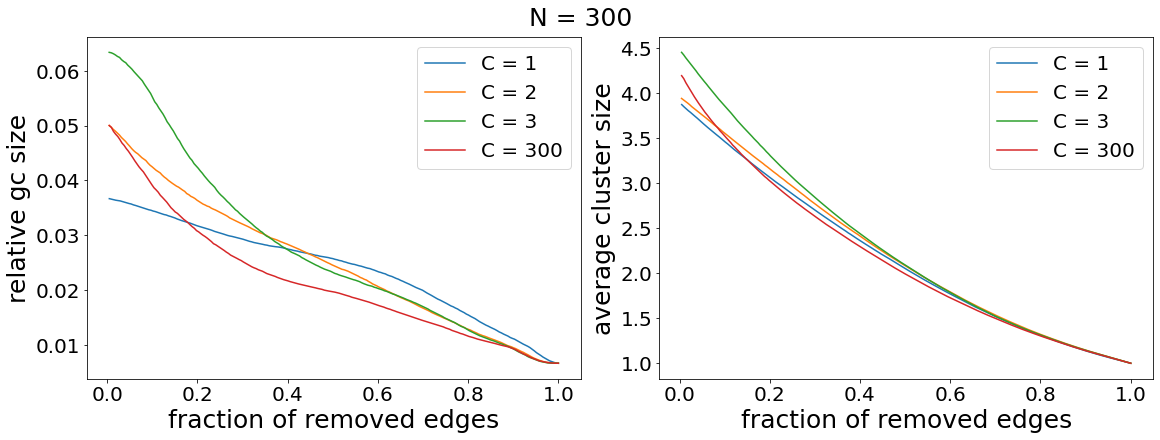

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Defina N de acordo com o CSV que você gerou
N = 300

# Valores de C para os quais você tem o CSV “random_{N}_{C}.csv”
Cs = [1, 2, 3, N]

# Use raw string ou escape duplo nas barras do Windows
base_path = r"C:\Users\victor.francheto\OneDrive - Hypera\Área de Trabalho\test-mlflow"

# Carrega cada CSV numa dict de DataFrames
dfs = {}
for C in Cs:
    file_path = os.path.join(base_path, f"random_{N}_{C}.csv")
    dfs[C] = pd.read_csv(file_path)

# Cria a figura com dois subplots lado a lado
fig, axes = plt.subplots(ncols=2, figsize=(16, 6), constrained_layout=True)
fig.suptitle(f'N = {N}', fontsize=25)

# Subplot 1: relative gc size (m1)
for C in Cs:
    axes[0].plot(dfs[C]['p'], dfs[C]['m1'], label=f'C = {C}')
axes[0].set_xlabel('fraction of removed edges', fontsize=25)
axes[0].set_ylabel('relative gc size', fontsize=25)
axes[0].tick_params(axis='both', labelsize=20)
axes[0].legend(fontsize=20)

# Subplot 2: average cluster size (s)
for C in Cs:
    axes[1].plot(dfs[C]['p'], dfs[C]['s'], label=f'C = {C}')
axes[1].set_xlabel('fraction of removed edges', fontsize=25)
axes[1].set_ylabel('average cluster size', fontsize=25)
axes[1].tick_params(axis='both', labelsize=20)
axes[1].legend(fontsize=20)

plt.show()
